In [1]:
import numpy as np

from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

import skimage
from PIL import Image
from datetime import datetime

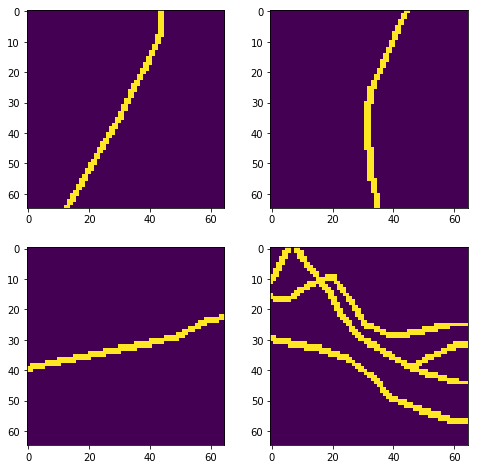

In [2]:
# Read and preprocess an example batch of images.
d = 65 # the image dimension

imfiles = ["debug/patch_and_label_0_2654_1785.png",
          "debug/patch_and_label_0_2731_2893.png",
          "debug/patch_and_label_0_3147_4232.png",
          "debug/patch_and_label_0_3609_4309.png"]
imlist = [Image.open(f) for f in imfiles]
imlist = [im.convert("L").crop((65, 0, 130, 65)).resize((d,d)) for im in imlist]
imlist = [np.array(im) for im in imlist]


rows = 2  # nrows in subplot
columns = 2  # ncols in subplot

# Plot each element in the batch.
fig=pl.figure(figsize=(8, 8))
for i in range(1, rows*columns + 1):
    im = imlist[i-1]
    y = np.array(im)
    fig.add_subplot(rows, columns, i)
    pl.imshow(y)


In [3]:
def make_noisy_image(y, d=d, shift=20):
    """A function to make a noisy version of an image."""
    y_hat = np.hstack((np.zeros((d,shift)), y[:, :-shift]))

    y_hat /= y_hat.max()  # normalize for adding noise
    y_hat = skimage.util.random_noise(y_hat, var=0.1)
    return y_hat

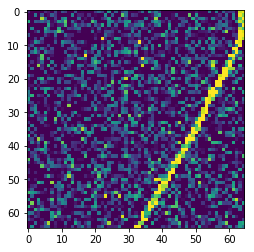

In [4]:
y = imlist[0]
y_hat = make_noisy_image(y)
y_hat *= 255
pl.imshow(y_hat)

In [5]:
y = y.astype(np.float64)
y_hat = y_hat.astype(np.float64)

In [6]:
from fftracer.training.loss import compute_ot_loss_matrix, make_distance_matrix
D = make_distance_matrix(y.shape[0])

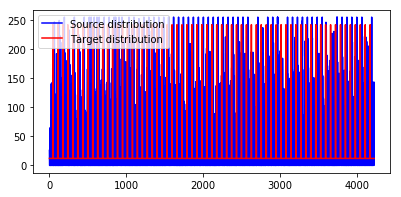

In [7]:
#%% plot the distributions
n = d**2
x = np.arange(n, dtype=np.float64)
pl.figure(1, figsize=(6.4, 3))
pl.plot(x, y_hat.flatten(), 'b', label='Source distribution')
pl.plot(x, y.flatten(), 'r', label='Target distribution')
pl.legend()

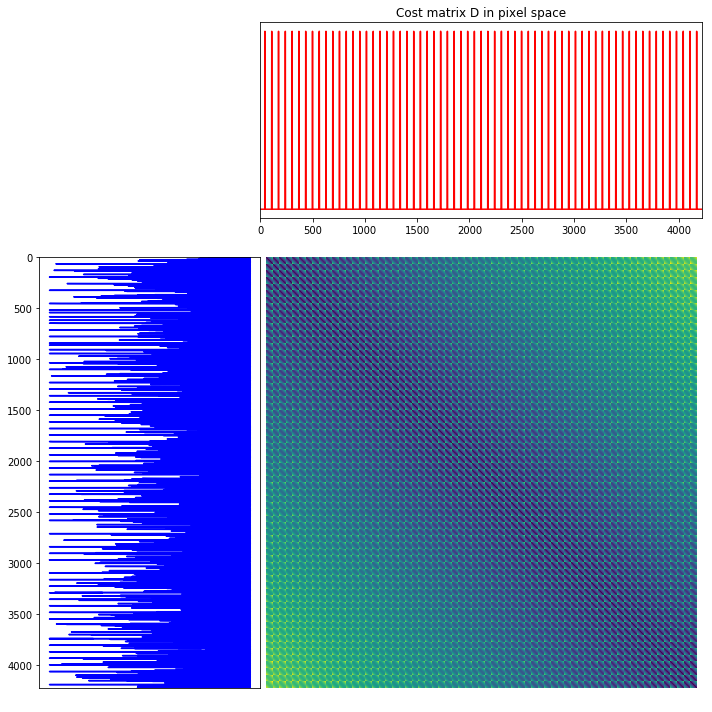

In [8]:
# plot distributions and loss matrix
pl.figure(2, figsize=(10, 10))
ot.plot.plot1D_mat(y_hat.flatten(), y.flatten(), D, 'Cost matrix D in pixel space')

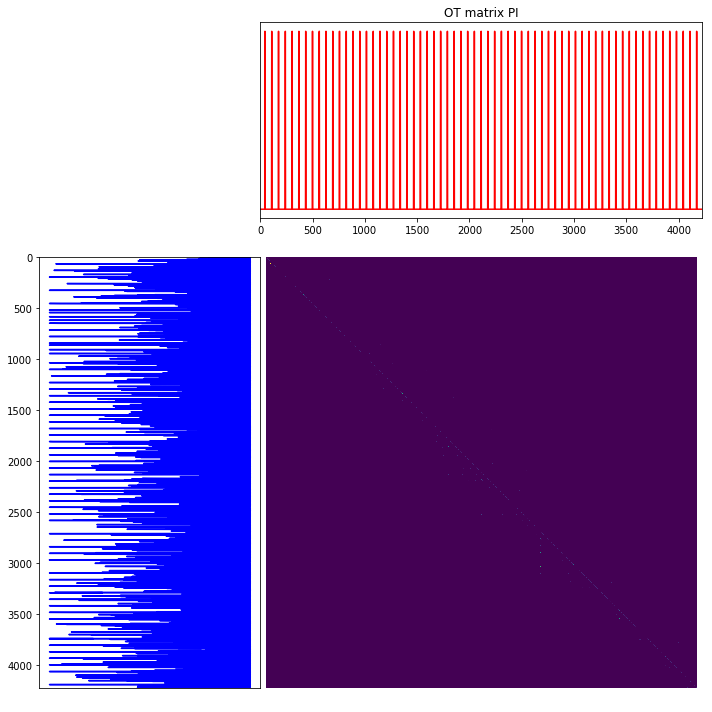

In [9]:
# solve the ot problem and show the result with source/target distributions
PI = compute_ot_loss_matrix(y, y_hat, D)

pl.figure(3, figsize=(10,10))
ot.plot.plot1D_mat(y_hat.flatten(), y.flatten(), PI, 'OT matrix PI')

In [10]:
PI.max()

0.0012521030484081823

Text(0.5, 1.0, 'Pi, optimal transport permutation matrix')

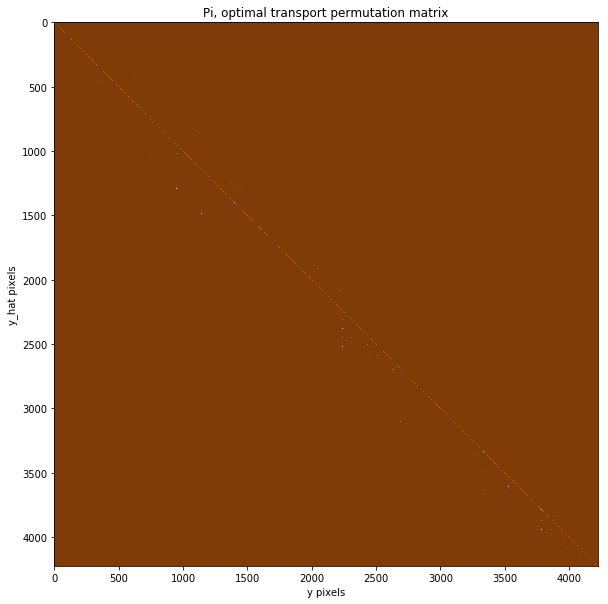

In [11]:
pl.figure(figsize=(10,10))
pl.imshow(PI, cmap="PuOr")
pl.ylabel("y_hat pixels")
pl.xlabel("y pixels")
pl.title("Pi, optimal transport permutation matrix")

In [12]:
from fftracer.training.loss import compute_pixel_loss

In [13]:
pixel_loss = compute_pixel_loss(PI, D)

Text(0.5, 1.0, 'Pixelwise OT Matrix')

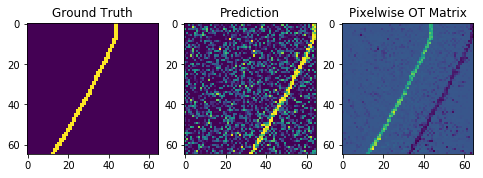

In [14]:
# Plot the loss for each element in the batch.
fig=pl.figure(figsize=(8, 8))
fig.add_subplot(1, 3, 1)
pl.imshow(y)
pl.title("Ground Truth")
fig.add_subplot(1, 3, 2)
pl.imshow(y_hat)
pl.title("Prediction")
fig.add_subplot(1, 3, 3)
pl.imshow(pixel_loss)
pl.title("Pixelwise OT Matrix")

# Batch example

In [15]:
batch = np.array(imlist)
batch = np.expand_dims(batch, axis=3)  # add a channels dim to simulate ffn training batches
print(batch.shape)

(4, 65, 65, 1)


In [16]:
y_hat_batch = [make_noisy_image(batch[i,:,:,0]) for i in range(batch.shape[0])]
y_hat_batch = np.array(y_hat_batch)
y_hat_batch = np.expand_dims(y_hat_batch, 3)
y_hat_batch.shape

(4, 65, 65, 1)

In [17]:
from fftracer.training.loss import compute_ot_loss_matrix_batch
pi_batch = compute_ot_loss_matrix_batch(batch, y_hat_batch, D)

In [18]:
print(pi_batch.shape)

(4, 4225, 4225)


In [19]:
batch_pixel_loss = [compute_pixel_loss(pi_batch[i, :, :], D) for i in range(pi_batch.shape[0])]
batch_pixel_loss = np.array(batch_pixel_loss)

In [20]:
batch_pixel_loss.shape

(4, 65, 65)

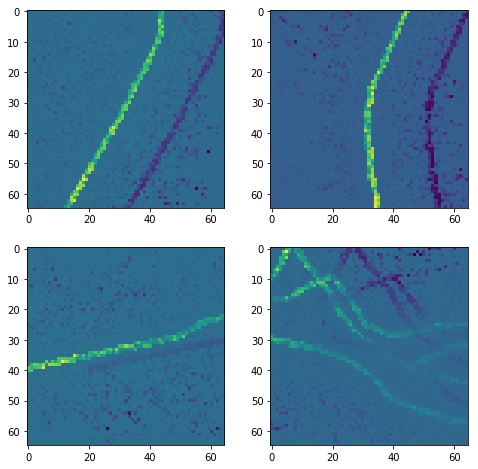

In [21]:
# Plot the loss for each element in the batch.
fig=pl.figure(figsize=(8, 8))
for i in range(1, rows*columns + 1):
    fig.add_subplot(rows, columns, i)
    pl.imshow(batch_pixel_loss[i-1, :, :])